In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report 

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
!git clone https://github.com/quainhan1110/Plant_Pathology.git

fatal: destination path 'Plant_Pathology' already exists and is not an empty directory.


In [3]:
df = pd.read_csv("/content/Plant_Pathology/plant-pathology-2020-fgvc7-data/train.csv")
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [4]:
import shutil
from shutil import copyfile

# delete temp dir
if os.path.exists('/content/Plant_Pathology/tmp/'):
    shutil.rmtree('/content/Plant_Pathology/tmp/')

os.mkdir('/content/Plant_Pathology/tmp/')

# create new directory for each category of foliar diseases
os.mkdir('/content/Plant_Pathology/tmp/healthy')
os.mkdir('/content/Plant_Pathology/tmp/multiple_diseases')
os.mkdir('/content/Plant_Pathology/tmp/rust')
os.mkdir('/content/Plant_Pathology/tmp/scab')

In [5]:
SOURCE = '/content/Plant_Pathology/plant-pathology-2020-fgvc7-data/images/'

TMP_DIR = '/content/Plant_Pathology/tmp/'

for i in range(len(df)):
  label = df.columns[np.argmax(df.iloc[i][1:])+1]
  filepath = os.path.join(SOURCE,df.iloc[i].image_id + ".jpg")
  dest = os.path.join(TMP_DIR,label,df.iloc[i].image_id + ".jpg")
  copyfile(filepath, dest)

sizes = []
labels = []
for subdir in os.listdir(TMP_DIR):
    print(subdir, len(os.listdir(os.path.join(TMP_DIR, subdir))))
    sizes.append(len(os.listdir(os.path.join(TMP_DIR, subdir))))
    labels.append(subdir)

rust 622
healthy 516
multiple_diseases 91
scab 592


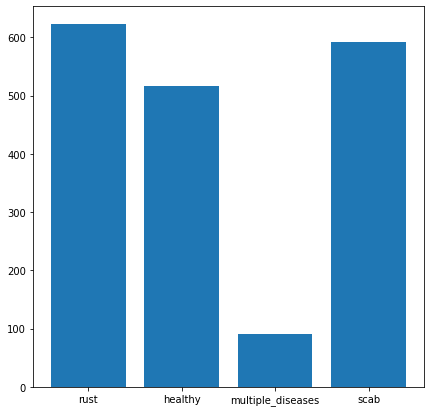

In [6]:
plt.figure(figsize=(7, 7))
plt.bar(labels, sizes)
plt.show()

In [7]:
healthy_dir = os.path.join(TMP_DIR, 'healthy')
mdiseases_dir = os.path.join(TMP_DIR, 'multiple_diseases')
scab_dir = os.path.join(TMP_DIR, 'scab')
rust_dir = os.path.join(TMP_DIR, 'rust')

healthy_files = os.listdir(healthy_dir)
mdiseases_files = os.listdir(mdiseases_dir)
scab_files = os.listdir(scab_dir)
rust_files = os.listdir(rust_dir) 

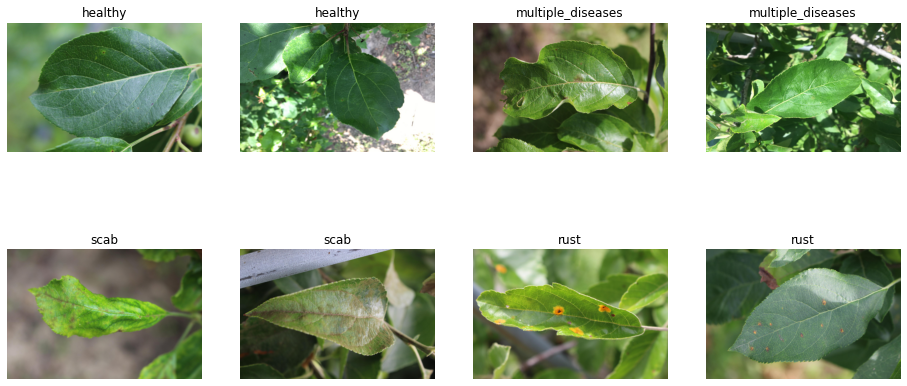

In [8]:
pic_index = 2

next_healthy = [os.path.join(healthy_dir, fname) for fname in healthy_files[pic_index-2:pic_index]]
next_mdiseases = [os.path.join(mdiseases_dir, fname) for fname in mdiseases_files[pic_index-2:pic_index]]
next_scab = [os.path.join(scab_dir, fname) for fname in scab_files[pic_index-2:pic_index]]
next_rust = [os.path.join(rust_dir, fname) for fname in rust_files[pic_index-2:pic_index]]


nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, img_path in enumerate(next_healthy+next_mdiseases+next_scab+next_rust):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.title(img_path.split('/')[-2])
    plt.imshow(img)
    
plt.show()

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  TMP_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 1821 files belonging to 4 classes.
Using 1457 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    TMP_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 1821 files belonging to 4 classes.
Using 364 files for validation.


In [12]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['healthy', 'multiple_diseases', 'rust', 'scab']


In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32, 4)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

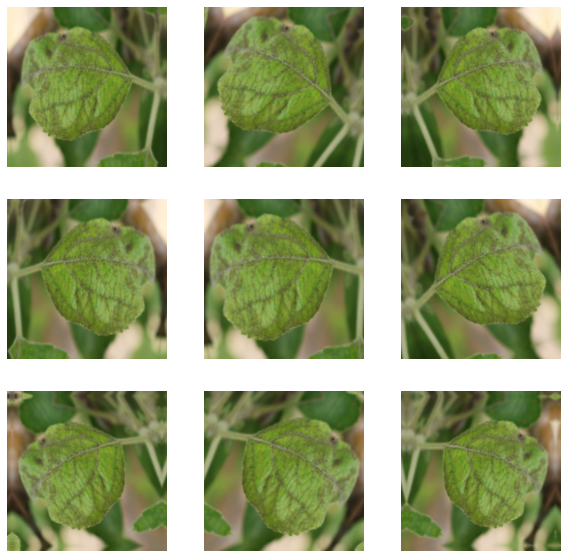

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

Use Early Stopping to halt the training of neural network at the right time, and CheckPointing to save the best model during training for later use.

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  verbose=2,
                                                  mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", 
                                                monitor="val_loss",
                                                mode="auto",
                                                verbose=2,
                                                save_best_only=True)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 1.2535 - accuracy: 0.3452
Epoch 1: val_loss improved from inf to 1.26829, saving model to best.h5
46/46 [==============================] - 8s 102ms/step - loss: 1.2535 - accuracy: 0.3452 - val_loss: 1.2683 - val_accuracy: 0.3791
Epoch 2/100
44/46 [===========================>..] - ETA: 0s - loss: 1.2126 - accuracy: 0.4128
Epoch 2: val_loss improved from 1.26829 to 1.21018, saving model to best.h5
46/46 [==============================] - 1s 31ms/step - loss: 1.2100 - accuracy: 0.4173 - val_loss: 1.2102 - val_accuracy: 0.4780
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 1.1468 - accuracy: 0.4811
Epoch 3: val_loss did not improve from 1.21018
46/46 [==============================] - 1s 27ms/step - loss: 1.1468 - accuracy: 0.4811 - val_loss: 1.2632 - val_accuracy: 0.4863
Epoch 4/100
45/46 [============================>.] - ETA: 0s - loss: 1.0144 - accuracy: 0.6049
Epoch 4: val_loss improved from 1.

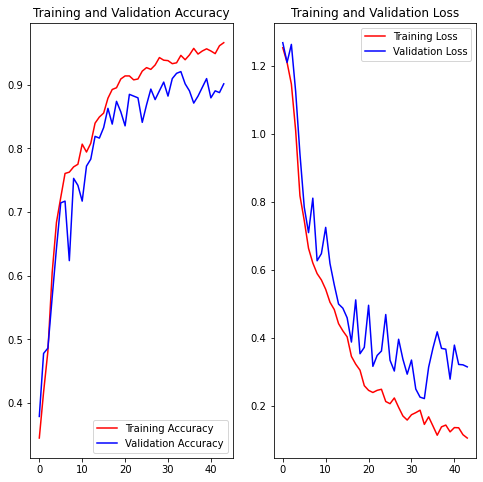

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = len(val_acc)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,'r', label='Training Accuracy')
plt.plot(epochs_range, val_acc,'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'r', label='Training Loss')
plt.plot(epochs_range, val_loss,'b', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
from keras_preprocessing import image

test_set = pd.read_csv("/content/Plant_Pathology/plant-pathology-2020-fgvc7-data/test.csv", index_col=0)

X_test = []
for index, data in test_set.iterrows():
    filepath = os.path.join(SOURCE, index + ".jpg")
    img = image.load_img(filepath, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)
    
X_test = np.vstack(X_test)

In [24]:
predictions = model.predict(X_test, batch_size= 10)
score = tf.nn.softmax(predictions)
score = np.array(score)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(score, columns = class_names)], axis=1).set_index("image_id")
df_out.to_csv('submission.csv')
df_out.head()

,healthy,multiple_diseases,rust,scab
image_id,,,,
Test_0,0.178514,0.192144,0.450828,0.178514
Test_1,0.175980,0.179777,0.468263,0.175980
Test_2,0.175141,0.175160,0.174980,0.474719
Test_3,0.473006,0.175345,0.175258,0.176390
Test_4,0.176398,0.181703,0.465501,0.176398
